# Neutral density
## (MOM6)

This notebook calculates neutral density ($\gamma$) in MOM6 using the algorithm developed by [Jackett and McDougall 1997](https://doi.org/10.1175/1520-0485(1997)027<0237:ANDVFT>2.0.CO;2).

Before using neutral density, be aware that this is a calculation that uses as a reference a climatology from the World Atlas, Levitus 1980. Therefore, **it shouldn't be used for simulations or datasets with climates/ocean states different to the 1980s (i.e. future projection simulations)**.

We use a python wrapper called `pygamma_n`, developed by Eric Firing and Filipe Fernandes; see https://currents.soest.hawaii.edu/hgstage/pygamma/ .

`pygamma_n` is available from `conda/analysis3-25.06`

## Information needed to adapt to MOM5:

Diagnostics needed:
 - `temp`: conservative temperature
 - `salt`: salinity
 - `ht`: depth at t-cells

Note that temperature in MOM5 is given as a conservative temperature in Kelvin, so you will need to (a) convert to Celsius and (b) go straight into calculating insitu temperature. All these diagnostics are in the t-cells, with `xt_ocean` and `yt_ocean` as longitude and latitude.

In [1]:
import intake

import numpy as np
import xarray as xr
from joblib import Parallel, delayed

import gsw
import pygamma_n

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean

import dask.distributed as dask
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

Initialize a dask client.

In [2]:
client = dask.Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44861/status,
Dashboard: /proxy/44861/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37163,Workers: 0
Dashboard: /proxy/44861/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33071,Total threads: 1
Dashboard: /proxy/39805/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:39867,


Load ACCESS-NRI default catalog:

In [3]:
catalog = intake.cat.access_nri

Define arguments needed to load data from a MOM6 experiment:

In [4]:
experiment = 'panant-01-zstar-ACCESSyr2'
start_time = '2000-01-01'
end_time = '2001-01-01'
frequency = '1mon'

Define the region to work with:

In [5]:
latitude_slice = slice(-70, -60)
longitude_slice = slice(-70, -40)
time_slice = slice(start_time, end_time)

Let's load the data - we will need temperature, salinity and depth - and select our region of interest. This recipe the `pygamma` function that only takes in 2D fields, so there is a parallelisation involved in calculating it for a time-varying 3D field. Be mindful of not making your region too big.

In [6]:
potential_temperature = catalog[experiment].search(variable = 'thetao', frequency = '1mon').to_dask(xarray_open_kwargs={"decode_timedelta": True})
practical_salinity = catalog[experiment].search(variable = 'so', frequency = '1mon').to_dask(xarray_open_kwargs={"decode_timedelta": True})
depth = catalog[experiment].search(variable = 'deptho', frequency = 'fx').to_dask()

In [7]:
potential_temperature = potential_temperature['thetao'].sel(time=time_slice, xh=longitude_slice, yh=latitude_slice)
practical_salinity = practical_salinity['so'].sel(time=time_slice, xh=longitude_slice, yh=latitude_slice)
depth = depth['deptho'].sel(xh=longitude_slice, yh=latitude_slice)

Load the data before doing any calculations. We are opening potential temperature (`thetao`) and practical salinity (`so`). 

In [8]:
potential_temperature = potential_temperature.load()
practical_salinity = practical_salinity.load()

`pygamma_n` takes in in-situ temperature and absolute salinity, so we will use `gsw` to convert. This involves calculating pressure as well! And annoyingly to go from MOM6's potential temperature to in situ temperature, we have to calculate conservative temperature as an intermediate step.

In [9]:
# Get values of coordinates
depth_coordinate = potential_temperature['z_l']
longitudes = potential_temperature['xh']
latitudes = potential_temperature['yh']

# Calculate pressure to use as a coordinate
pressure_coordinate = gsw.p_from_z(-depth_coordinate, latitudes)

# Calculate absolute salinity
absolute_salinity = gsw.SA_from_SP(practical_salinity, pressure_coordinate, longitudes, latitudes).rename('SA')
# Calculate conservative temperature (needed to calculate in situ temperatures)
conservative_temperature = gsw.CT_from_pt(absolute_salinity, potential_temperature)
# Calculate insitu temperature 
insitu_temperature = gsw.t_from_CT(absolute_salinity, conservative_temperature, pressure_coordinate).rename('t')

In [10]:
insitu_temperature = insitu_temperature.load()

The `pygamma_n` function to calculate neutral densities takes 2D fields (cross sections with depth and lat/lon). So for our time-varying, 3D fields we are going to need to "iterate" twice, once through time and once through longitudes. We will define a function that calculates $\gamma$ for a certain time step and longitude, and then use the Parallel function from `joblib` to calculate each cross section in parallel.

In [11]:
def neutral_density(t, s, indexes):
    """
    Calculates neutral density (gamma) for a given longitude and time 
    of in-situ temperature and practical salinity datasets.
    """
    # First index should be time, second longitude
    time_idx = indexes[0]
    long_idx = indexes[1]
    pressure = gsw.p_from_z(-t['z_l'], t['yh'])
    
    gamma, dg_lo, dg_hi = pygamma_n.gamma_n(s.isel(time=time_idx, xh=long_idx).transpose(), 
                                            t.isel(time=time_idx, xh=long_idx).transpose(), 
                                            pressure.transpose(), 
                                            (t['xh'][long_idx].item()*(t['yh']*0+1)), 
                                            (t['yh']))
    gamma  = gamma.T
    
    return gamma

Now that we have our function, we need to make a list of arguments we want to feed it (every combination possible of time and longitude indexes):

In [12]:
# Create a list of pairs that have a unique time, lon index
Nt = len(insitu_temperature['time'])
Nx = len(insitu_temperature['xh'])
args_list = [[i, j] for i in range(Nt) for j in range(Nx)]

The cell below uses Parallel to run the neutral density function for each cross section in parallel, where the results are arranged as a list:

In [13]:
# Run the neutral_density function in parallel
results = Parallel(n_jobs=-1)(delayed(neutral_density)(insitu_temperature, practical_salinity, arg) for arg in args_list)

We need to reshape that list onto a DataArray with appropriate dimensions:

In [14]:
# Reshape the results into the original dataset shape
gamma = np.nan * np.zeros(np.shape(insitu_temperature))
for idx, result in enumerate(results):
    i, j = divmod(idx, Nx)
    gamma[i, :, :, j] = result

In [15]:
# Make it into a dataarray with dimensions and attributes
gamma = xr.DataArray(gamma, dims = insitu_temperature.dims, coords = insitu_temperature.coords, name = 'gamma')
gamma.attrs['long_name'] = 'neutral density'
gamma.attrs['units'] = 'kg/m3'

In [19]:
# Put the nans back in land (pygamma has a fillvalue of zero)
gamma = xr.where(np.isnan(insitu_temperature), np.nan, gamma)

Done!

# Plotting

Let's create a land mask and do a map of the time mean neutral density at the surface:

In [21]:
# Create a land mask
land_mask = xr.where(np.isnan(depth), 1, np.nan)

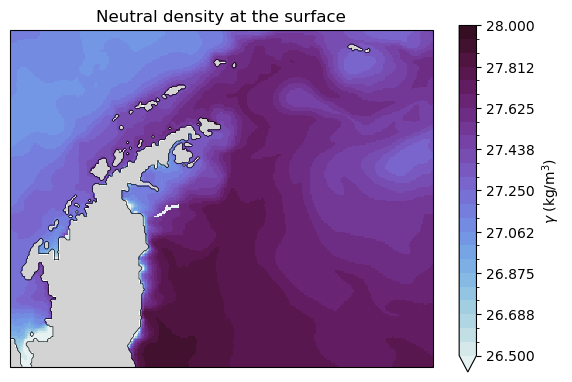

In [23]:
fig = plt.figure(figsize = (15, 15))

projection = ccrs.Mercator(central_longitude = -55)
axs = fig.add_subplot(121, projection = projection)

# Set the region
axs.set_extent([-70, -40, -70, -60], crs = ccrs.PlateCarree())

# Add model land mask
land_mask.plot.contourf(ax=axs, colors='lightgrey', transform=ccrs.PlateCarree(), add_colorbar=False, zorder=2)

# Add model coastline
land_mask.fillna(0).plot.contour(ax=axs, colors='k', levels=[0, 1], 
                                 transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5, zorder=3)

# Plot time-mean neutral density at the surface
gamma.mean('time').isel(z_l = 0).plot.pcolormesh(ax=axs, cmap = cmocean.cm.dense, transform=ccrs.PlateCarree(),
                                                 vmin = 26.5, vmax = 28, levels = 25,
                                                 cbar_kwargs = {'label': '$\\gamma$ (kg/m$^{3}$)',
                                                                'shrink':.3})
axs.set_title('Neutral density at the surface');

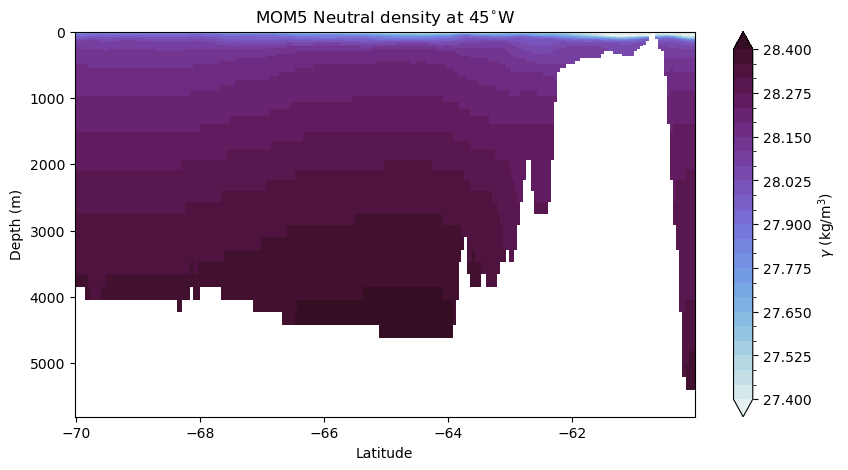

In [25]:
fig, axs = plt.subplots(figsize = (10, 5))

gamma.mean('time').sel(xh = -45, method = 'nearest').plot.pcolormesh(ax=axs, cmap=cmocean.cm.dense,
                                                                     vmin = 27.4, vmax = 28.4, levels = 25,
                                                                     cbar_kwargs={'label': '$\\gamma$ (kg/m$^{3}$)'})
axs.invert_yaxis()
axs.set_ylabel('Depth (m)');
axs.set_xlabel('Latitude');
axs.set_title('MOM5 Neutral density at 45$^{\circ}$W');